In [17]:
import os
import pandas as pd
from google.cloud import bigquery
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

df_daily = pd.read_gbq("select * from `intense-arbor-186802`.sample_data.top_3_prods",
                 project_id="intense-arbor-186802")

In [18]:
df_daily["resource_type"] = np.where(df_daily["resource_type"].str.contains("VCPU"),"VCPU",
         np.where(df_daily["resource_type"].str.contains("Fee"), "Licensing Fees",
                  np.where(df_daily["resource_type"].str.contains("GPU"), "GPU",
                           np.where(df_daily["resource_type"].str.contains("CPU"), "CPU",
                                    np.where(df_daily["resource_type"].str.contains("Egress"), "Egress",
                                             np.where(df_daily["resource_type"].str.contains("PD"), "PD", 
                                                      np.where(df_daily["resource_type"].str.contains("Load Balancing"),"Load Balancing",
                                                              np.where(df_daily["resource_type"].str.contains("Custom instance"),"Custom Instance",
                                                                       np.where(df_daily["resource_type"].str.contains(" Regional Storage"),"Regional Storage",
                                                                               np.where(df_daily["resource_type"].str.contains("Multi-Regional Storage"),"Multi-Regional Storage",
                                                                                       np.where(df_daily["resource_type"].str.contains("Static Ip"), "Static Ip Charge",
                                                                                               df_daily["resource_type"]
                                                                                               )
                                                                                       )
                                                                               )
                                                                      )
                                                              )
                                                    )
                                               )
                                      )
                            )
                    )
                                    )
                                             
                      
df_daily["resource_type"] = np.where((df_daily["resource_type"] == "Regional Storage US")|
                                     (df_daily["resource_type"] == "Regional Storage Asia"),
                                     "Regional Storage",
                                     df_daily["resource_type"])

In [19]:
df_daily = df_daily[(df_daily["resource_type"] != "Custom Instance")]
df_daily = df_daily[(df_daily["resource_type"] != "GPU")]
df_daily["resource_type"].unique()

array(['Analysis', 'Vpn Tunnel', 'Storage Image', 'Active Storage',
       'Static Ip Charge', 'Streaming Insert', 'Long Term Storage',
       'Regional Storage', 'PD', 'Multi-Regional Storage', 'Egress',
       'CPU', 'VCPU', 'Licensing Fees', 'Load Balancing'], dtype=object)

In [20]:
def plot_prod(product, legend=True):
    df_daily_prod = df_daily[df_daily["product"] == product][["start_time","unit","cost","resource_type"]]

    units_available = list(df_daily_prod["unit"].unique())
    print(f"Units available:{units_available}")
    unit = input("Enter unit: ") 

    df_daily_prod_unit = df_daily_prod[df_daily_prod["unit"] ==unit]
    df_daily_prod_unit_pivot = pd.pivot_table(df_daily_prod_unit, 
                                         values="cost", 
                                         index="start_time", 
                                         columns=["unit","resource_type"])

    for col in df_daily_prod_unit_pivot.columns:
        df_daily_prod_unit_pivot[col] = np.log(df_daily_prod_unit_pivot[col])

    df_daily_prod_unit_pivot.plot(title=product,figsize=(15,10),legend = legend)

## BigQuery Cost in Bytes

BigQuery costs in bytes are often consumed for either Analysis Queries(blue) or Streaming Inserts(orange). Examples of Analysis Queries include SQL queries, scripts, UDFs and other functions that can be exercised on BQ tables. Streaming Inserts figures track the cost involved in streaming data directly into BigQuery instead of using traditional batch updates. As expected, Streaming Inserts are more expensive ($0.01 per 200 MB) compared to batch uploads which are free when slot pricing is used.

In the graph below, while Analysis Queries are fairly stable over the 7 month window, Streaming Insert costs have spiked early in the year and have risen in a step-wise fashion. The steps are clear during the beginning of 2017-06 with another escalation during the mid of 2017-07. 

Units available:['bytes', 'byte-seconds']
Enter unit: bytes


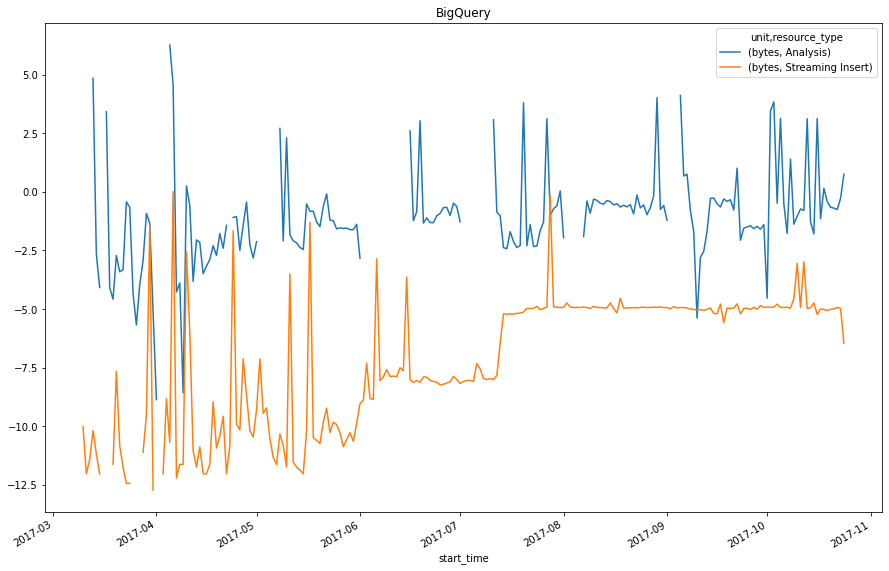

In [13]:
plot_prod("BigQuery")

## BigQuery Cost in Byte-Seconds

BigQuery costs in byte-seconds are measured for storage. Two types of storage are recorded in the billing data: Active Storage(blue) and Long Term Store(Orange). Active storage involves tables that have been updated for 90 days prior to storage classification. Long-term storage involves tables that has not been modified for 90 consecutive days. The price of storage is halved for tables that transition from Active to Long Term Storage.

From the graph below, we can see that the Long Term Storage lines have breaks showing periods of time when teams retire datasets that are no longer in use. The transition of tables from Active to Long Term Storage is also visibile in the first couple of months in the graph. While the Active Storage tables grow and remain undeleted, we see the peak for the costs rise at the end of the 90 day period (at about April-mid). Once the 90 day timeline hits, the Active costs go down due to the halving while Long Term costs rise from April-mid till end of May. Similar patterns later in the year become difficult to generalize since byte-seconds later in the year don't register the generation of new tables or deletion of old ones.

Units available:['bytes', 'byte-seconds']
Enter unit: byte-seconds


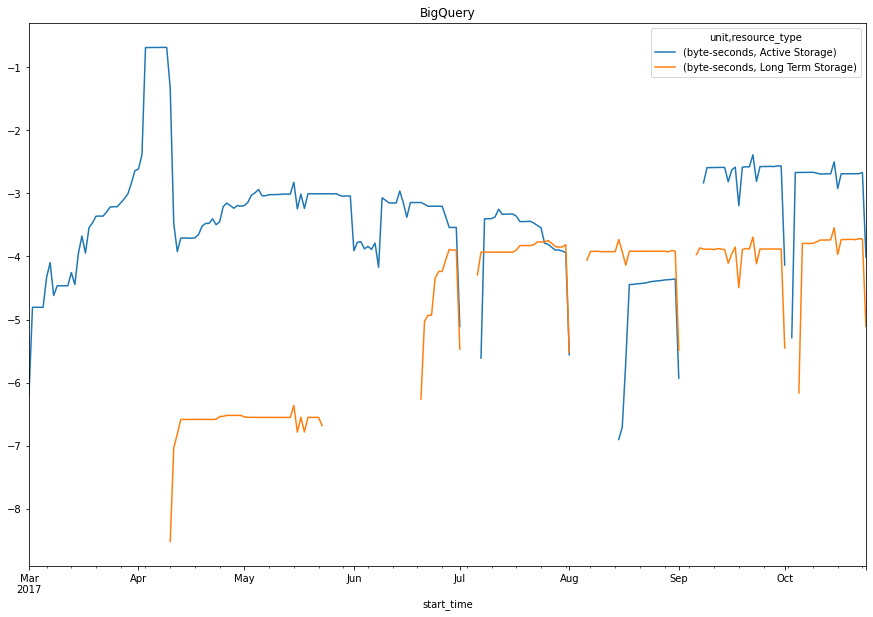

In [14]:
plot_prod("BigQuery")

## Cloud Storage Cost in Byte-Seconds

The Regional(orange) and Multi-Regional Storage(blue) measurements capture what fraction of GCS costs are incurred due to location. It costs more to store data in multiple regions; while availability is higher and latency is lower for apps deployed in these regions, the storage is more expensive. 

In the graph below, we see higher use of regional storage (likely for testing in 1 region before multi-region rollout of apps), thse costs plummet at the end where Multi-regional storage is likely leveraged for later deployments.

Units available:['byte-seconds', 'requests']
Enter unit: byte-seconds


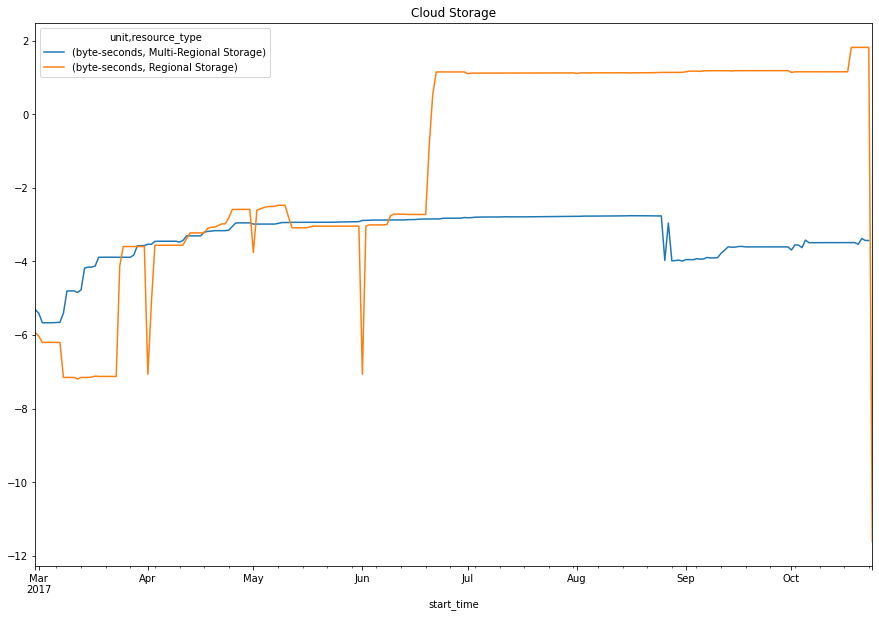

In [21]:
plot_prod("Cloud Storage")

## Cloud Storage Cost in Requests

Units available:['byte-seconds', 'requests']
Enter unit: requests


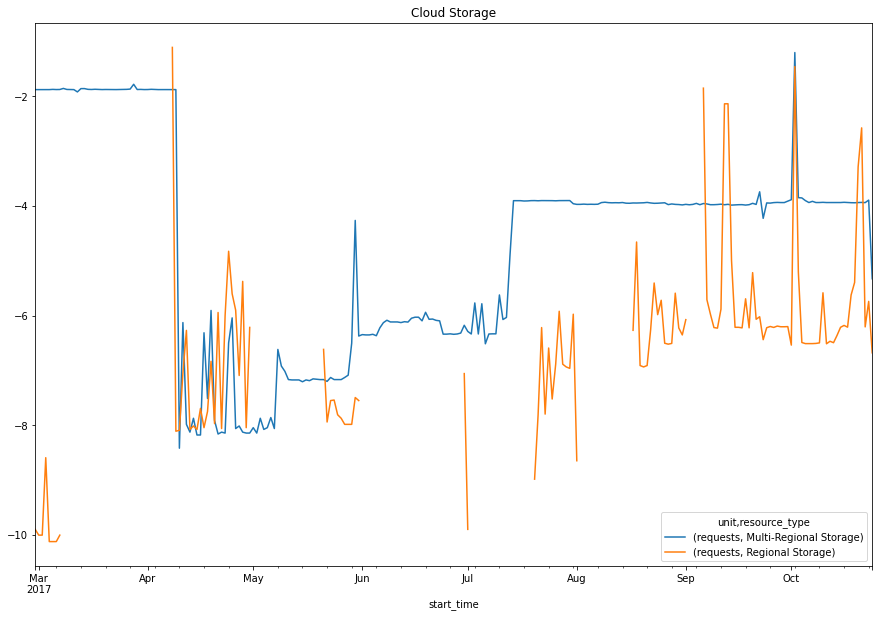

In [16]:
plot_prod("Cloud Storage")

In [133]:
df_daily_prod[["unit","resource_type"]].groupby(["unit","resource_type"]).size()

unit          resource_type   
byte-seconds  PD                  1765
              Storage Image        238
bytes         Egress              1598
seconds       CPU                  713
              Licensing Fees       852
              Load Balancing       874
              Static Ip Charge     400
              VCPU                3891
              Vpn Tunnel           238
dtype: int64

In [ ]:
! git add .
! git commit -m "adding graphs "